# Sample-Based SDF Training
Training a ReLU MLP to learn SDF using point samples


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from ainr import generate_polygons, ReluMLP, plot_cell_sdf3
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)


Number of polygons: 3
Polygon 0: 32 vertices, center=[-0.5 -0.5]
Polygon 1: 32 vertices, center=[ 0.5 -0.5]
Polygon 2: 32 vertices, center=[-0.5  0.5]


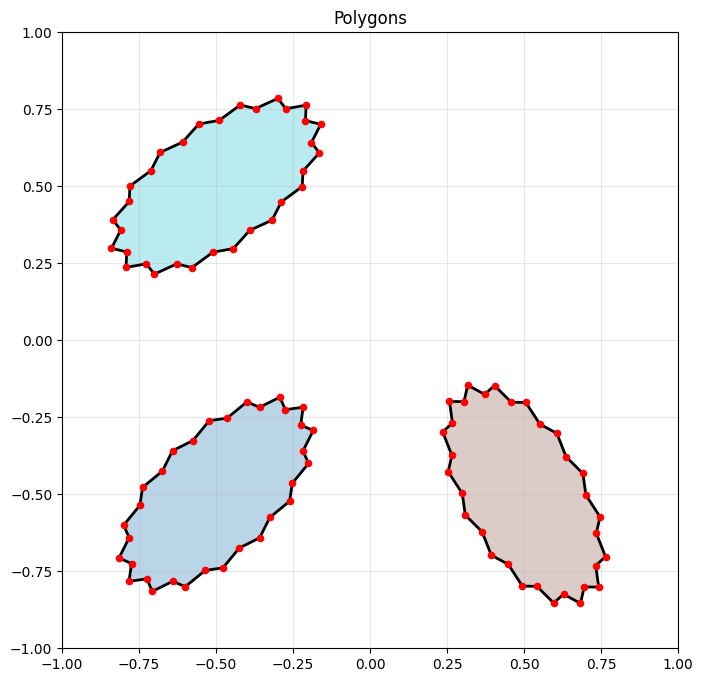

In [2]:
# Generate polygons
polygons = generate_polygons('3x16', convex=False, stretch=(1, 0.5), 
                            star_ratio=0.9, rotation=[np.pi/4, -np.pi/3, np.pi/5])

print(f"Number of polygons: {len(polygons)}")
for i, poly in enumerate(polygons):
    print(f"Polygon {i}: {len(poly)} vertices, center={poly.mean(axis=0)}")

# Visualize
from ainr import plot_polygons
plot_polygons(polygons)


In [3]:
def compute_ground_truth_sdf(points, polygons):
    """Compute ground truth SDF for points given polygons."""
    points = np.asarray(points)
    sdf = np.full(len(points), np.inf)
    
    for poly in polygons:
        v = np.asarray(poly)
        
        # Compute distance to this polygon's edges
        poly_distances = np.full(len(points), np.inf)
        for i in range(len(v)):
            v1, v2 = v[i], v[(i + 1) % len(v)]
            edge_vec = v2 - v1
            edge_len_sq = np.dot(edge_vec, edge_vec)
            
            if edge_len_sq < 1e-10:
                continue
            
            t_closest = np.clip(np.dot(points - v1, edge_vec) / edge_len_sq, 0, 1)
            closest_points = v1 + t_closest[:, None] * edge_vec
            edge_distances = np.linalg.norm(points - closest_points, axis=1)
            poly_distances = np.minimum(poly_distances, edge_distances)
        
        # Ray casting for inside/outside
        v_next = np.roll(v, -1, axis=0)
        py = points[:, 1:2]
        px = points[:, 0:1]

        v_y, v_next_y = v[:, 1], v_next[:, 1]
        v_x, v_next_x = v[:, 0], v_next[:, 0]

        crosses = ((v_y <= py) & (py < v_next_y)) | ((v_next_y <= py) & (py < v_y))
        dy = v_next_y - v_y
        valid = np.abs(dy) > 1e-12
        safe_dy = np.where(valid, dy, 1.0)

        t_cross = (py - v_y) / safe_dy
        x_cross = v_x + t_cross * (v_next_x - v_x)

        crossings_right = crosses & valid & (x_cross > px)
        inside_poly = np.sum(crossings_right, axis=1) % 2 == 1
        
        poly_sdf = np.where(inside_poly, -poly_distances, poly_distances)
        sdf = np.minimum(sdf, poly_sdf)
    
    return sdf


Generated 1980 training samples
SDF range: [-0.1741, 1.0422]
Interior points (SDF < 0): 538
Exterior points (SDF > 0): 993


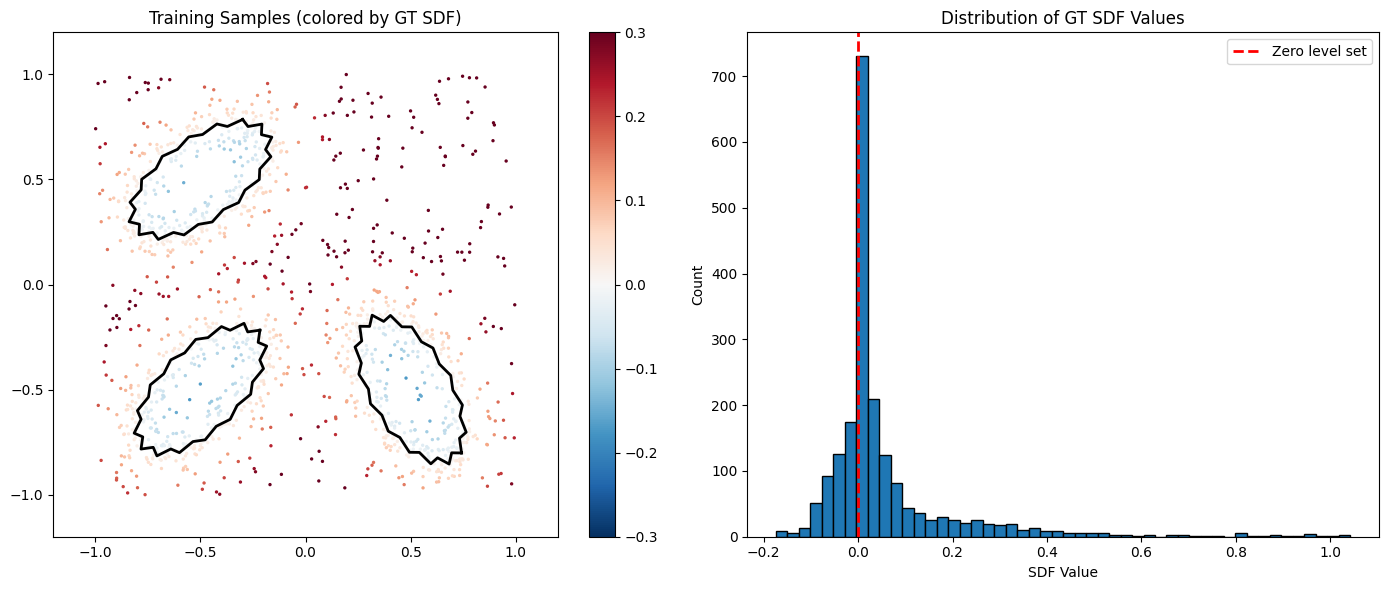

In [4]:
def generate_training_samples(polygons, n_surface=500, n_near=1000, n_random=500):
    """Generate training samples: on surface, near surface, and random."""
    all_points = []
    
    # 1. Surface samples (SDF = 0)
    for poly in polygons:
        v = np.asarray(poly)
        n_per_poly = n_surface // len(polygons)
        
        # Sample uniformly along edges
        for i in range(len(v)):
            v1, v2 = v[i], v[(i + 1) % len(v)]
            n_edge = n_per_poly // len(v)
            t = np.random.rand(n_edge, 1)
            edge_points = v1 + t * (v2 - v1)
            all_points.append(edge_points)
    
    # 2. Near-surface samples (small random offset from surface)
    surface_points = np.vstack(all_points)
    offsets = np.random.randn(n_near, 2) * 0.05  # Small perturbations
    near_points = surface_points[np.random.choice(len(surface_points), n_near)] + offsets
    all_points.append(near_points)
    
    # 3. Random samples in [-1, 1]^2
    random_points = np.random.rand(n_random, 2) * 2 - 1
    all_points.append(random_points)
    
    # Combine all samples
    samples = np.vstack(all_points)
    
    # Compute ground truth SDF
    sdf_gt = compute_ground_truth_sdf(samples, polygons)
    
    return samples, sdf_gt

# Generate samples
samples, sdf_gt = generate_training_samples(polygons)
print(f"Generated {len(samples)} training samples")
print(f"SDF range: [{sdf_gt.min():.4f}, {sdf_gt.max():.4f}]")
print(f"Interior points (SDF < 0): {(sdf_gt < 0).sum()}")
print(f"Exterior points (SDF > 0): {(sdf_gt > 0).sum()}")

# Visualize samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: All samples colored by SDF
scatter = ax1.scatter(samples[:, 0], samples[:, 1], c=sdf_gt, 
                     s=2, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
for poly in polygons:
    closed = np.vstack([poly, poly[0:1]])
    ax1.plot(closed[:, 0], closed[:, 1], 'k-', linewidth=2)
ax1.set_xlim(-1.2, 1.2)
ax1.set_ylim(-1.2, 1.2)
ax1.set_aspect('equal')
ax1.set_title('Training Samples (colored by GT SDF)')
plt.colorbar(scatter, ax=ax1)

# Plot 2: Histogram of SDF values
ax2.hist(sdf_gt, bins=50, edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero level set')
ax2.set_xlabel('SDF Value')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of GT SDF Values')
ax2.legend()

plt.tight_layout()
plt.show()


In [5]:
hidden_dim = 16
num_layers = 3
mlp = ReluMLP(2, hidden_dim, num_layers, skip_connections=False)

print(f"Network architecture:")
print(f"  Input dim: 2")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Num layers: {num_layers}")
print(f"  Output dim: 1")
print(f"  Skip connections: False")
print(f"\nTotal parameters: {sum(p.numel() for p in mlp.parameters())}")


Network architecture:
  Input dim: 2
  Hidden dim: 16
  Num layers: 3
  Output dim: 1
  Skip connections: False

Total parameters: 609


In [6]:
# Convert to tensors
X_train = torch.tensor(samples, dtype=torch.float32)
y_train = torch.tensor(sdf_gt, dtype=torch.float32).unsqueeze(1)

# Training setup
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
batch_size = 256
episodes = 10_000
loss_history = []

# Loss function
def sdf_loss(pred, target):
    """MSE loss for SDF prediction."""
    return torch.mean((pred - target) ** 2)

# Training loop
pbar = tqdm(range(episodes))
for epoch in pbar:
    # Shuffle and create batches
    indices = torch.randperm(len(X_train))
    
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, len(X_train), batch_size):
        batch_idx = indices[i:i+batch_size]
        X_batch = X_train[batch_idx]
        y_batch = y_train[batch_idx]
        
        # Forward pass
        optimizer.zero_grad()
        pred = mlp(X_batch)
        loss = sdf_loss(pred, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    loss_history.append(avg_loss)
    
    if epoch % 100 == 0:
        pbar.set_postfix({'loss': f'{avg_loss:.6f}'})

print(f"\nFinal loss: {loss_history[-1]:.6f}")


100%|██████████| 10000/10000 [00:26<00:00, 380.61it/s, loss=0.000056]


Final loss: 0.000059


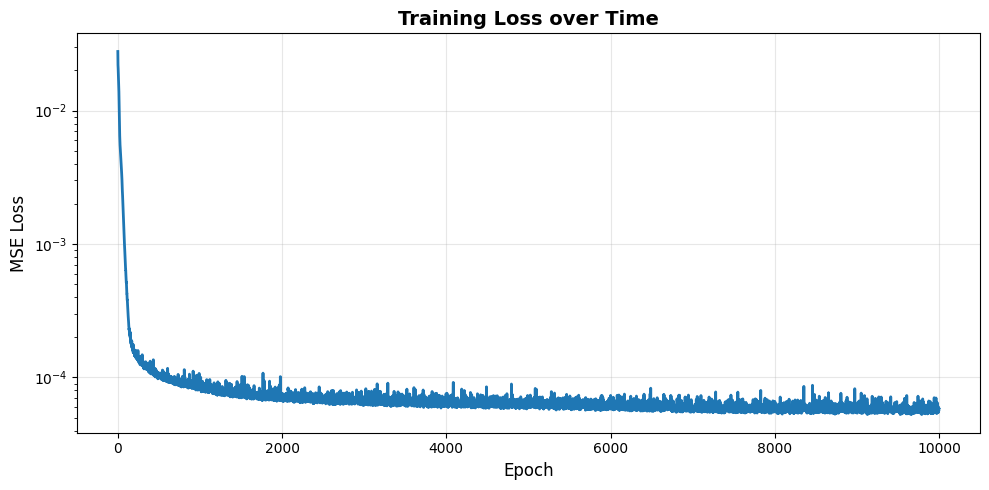

Initial loss: 0.027754
Loss at epoch 1000: 0.000098
Loss at epoch 5000: 0.000068
Final loss: 0.000059


In [7]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss over Time', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Show loss at different stages
print(f"Initial loss: {loss_history[0]:.6f}")
print(f"Loss at epoch 1000: {loss_history[999]:.6f}")
print(f"Loss at epoch 5000: {loss_history[4999]:.6f}")
print(f"Final loss: {loss_history[-1]:.6f}")


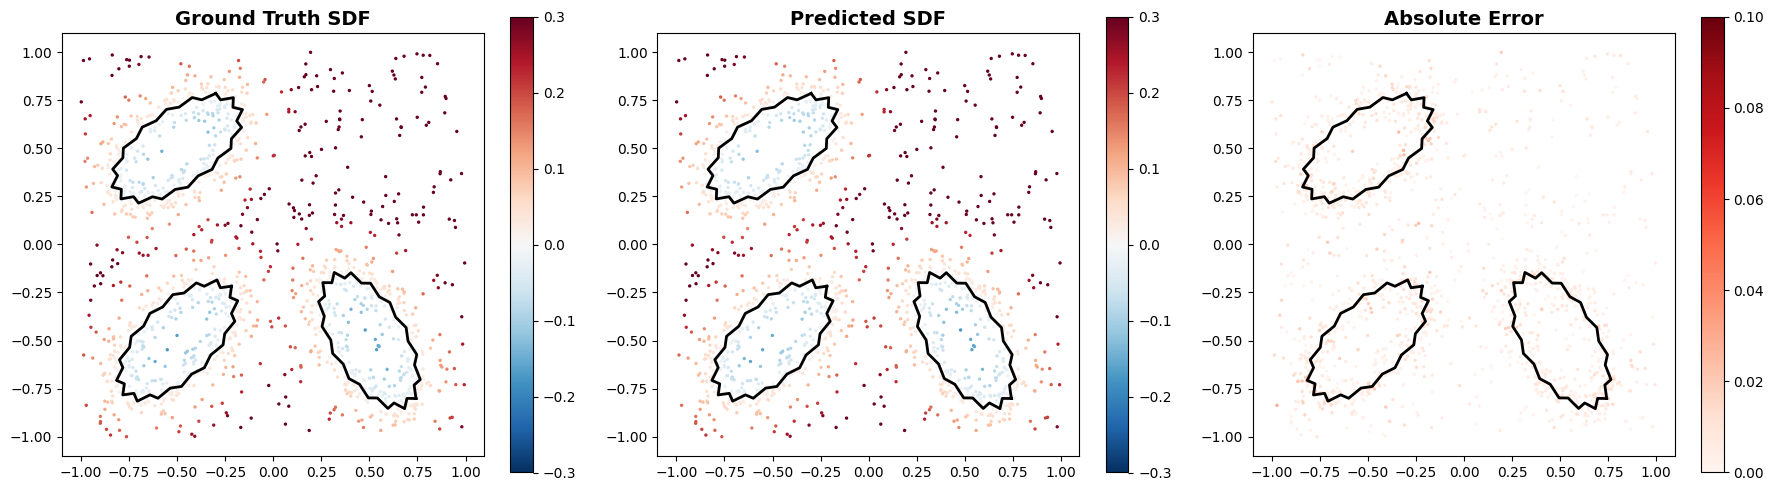


Error statistics:
  Mean absolute error: 0.005978
  Max absolute error: 0.030399
  Median absolute error: 0.004944


In [8]:
# Evaluate on test grid
with torch.no_grad():
    pred_sdf = mlp(X_train).squeeze().numpy()

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ground truth
scatter1 = axes[0].scatter(samples[:, 0], samples[:, 1], c=sdf_gt, 
                          s=2, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
for poly in polygons:
    closed = np.vstack([poly, poly[0:1]])
    axes[0].plot(closed[:, 0], closed[:, 1], 'k-', linewidth=2)
axes[0].set_title('Ground Truth SDF', fontsize=14, fontweight='bold')
axes[0].set_aspect('equal')
plt.colorbar(scatter1, ax=axes[0])

# Prediction
scatter2 = axes[1].scatter(samples[:, 0], samples[:, 1], c=pred_sdf, 
                          s=2, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
for poly in polygons:
    closed = np.vstack([poly, poly[0:1]])
    axes[1].plot(closed[:, 0], closed[:, 1], 'k-', linewidth=2)
axes[1].set_title('Predicted SDF', fontsize=14, fontweight='bold')
axes[1].set_aspect('equal')
plt.colorbar(scatter2, ax=axes[1])

# Error
error = np.abs(pred_sdf - sdf_gt)
scatter3 = axes[2].scatter(samples[:, 0], samples[:, 1], c=error, 
                          s=2, cmap='Reds', vmin=0, vmax=0.1)
for poly in polygons:
    closed = np.vstack([poly, poly[0:1]])
    axes[2].plot(closed[:, 0], closed[:, 1], 'k-', linewidth=2)
axes[2].set_title('Absolute Error', fontsize=14, fontweight='bold')
axes[2].set_aspect('equal')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nError statistics:")
print(f"  Mean absolute error: {error.mean():.6f}")
print(f"  Max absolute error: {error.max():.6f}")
print(f"  Median absolute error: {np.median(error):.6f}")


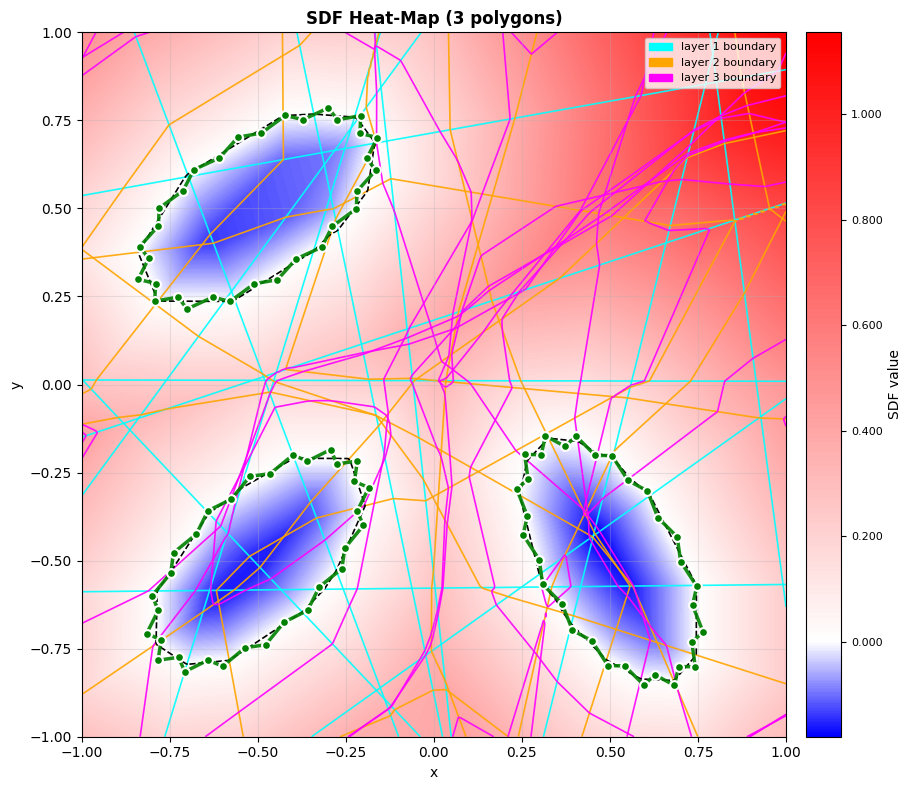

In [9]:
# Use plot_cell_sdf3 for full visualization
plot_cell_sdf3(mlp, splines=None, polygons=polygons)
